# Survival Analysis Notebook

**IMPORTANT**: this notebook is now **out of date** with the actual analysis code in the server backend (notably, the new analysis code uses a different way to split between tests and controls and classifying what a control is). 

In [1]:
using Pkg
Pkg.activate("../")

 Activating environment at `~/projects/cansat/backend/Project.toml`


In [16]:
using HTTP, JSON, DataFrames, Survival, Plots, StatsModels, RCall, StatsBase

┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1278
┌ Info: Precompiling RCall [6f49c342-dc21-5d91-9882-a32aef131414]
└ @ Base loading.jl:1278


## Approach

The new cBioPortal API documentation is available from https://www.cbioportal.org/api/swagger-ui.html.

Ideally, we should be able to define a very simple configuration specifying the `study_id` and the `genes` we are interested in as well as their thresholds. It might look something like the following JSON:

```json
{ 
    "study_id": "brca_tcga_pub2015", 
    "genes": [
        { "hugo": "BRCA1",
          "side": "above",
          "zscore": 2.0 },
        { "hugo": "BRCA2",
          "side": "above",
          "zscore": 1.5 }
    ]
}
```

Let's imagine we received this JSON from the frontend.

In [17]:
config_json = """
{ 
    "study_id": "brca_tcga_pub2015", 
    "genes": [
        { "hugo": "BRCA1",
          "entrez": 672,
          "side": "above",
          "zscore": 1.0 },
        { "hugo": "BRCA2",
          "entrez": 675,
          "side": "above",
          "zscore": 1.0 }
    ]
}
"""

"{ \n    \"study_id\": \"brca_tcga_pub2015\", \n    \"genes\": [\n        { \"hugo\": \"BRCA1\",\n          \"entrez\": 672,\n          \"side\": \"above\",\n          \"zscore\": 1.0 },\n        { \"hugo\": \"BRCA2\",\n          \"entrez\": 675,\n          \"side\": \"above\",\n          \"zscore\": 1.0 }\n    ]\n}\n"

Let's first parse it into a Julia `Dict` type.

In [18]:
function parse_config(jsonstring)
    return JSON.Parser.parse(jsonstring)
end

parse_config (generic function with 1 method)

In [19]:
config = parse_config(config_json)

Dict{String,Any} with 2 entries:
  "study_id" => "brca_tcga_pub2015"
  "genes"    => Any[Dict{String,Any}("side"=>"above","entrez"=>672,"zscore"=>1.…

We now need to obtain the following data from the cBioPortal API:

1. Clinical data of patients' a) days to last follow up, and b) status at last follow up in terms of either overall survival (OS) or disease-free-survival (DFS). 
2. mRNA expression data for the specified genes. 

Sufficient data for either of these steps may often be unavailable, and these error cases need to be handled judiciously.

### API Requests

A handy abstraction for making requests to the cBioPortal API:

In [20]:
function portal_request_get(path; query=nothing)
    baseurl = "https://www.cbioportal.org/api"
    request = HTTP.get(baseurl*path, query=query)
    json = request.body |> String |> JSON.Parser.parse
    return json
end

portal_request_get (generic function with 1 method)

In [21]:
function portal_request_post(path, body; query=nothing)
    baseurl = "https://www.cbioportal.org/api"
    body_json = JSON.Writer.json(body)
    request = HTTP.post(baseurl*path, ["Content-Type" => "application/json"], body_json, query=query)
    json = request.body |> String |> JSON.Parser.parse
    return json
end

portal_request_post (generic function with 1 method)

### Clinical Data

The clinical data is accessible from an endpoint that resembles `/studies/brca_tcga_pub2015/clinical-data?clinicalDataType=PATIENT`, which returns an array of JSON objects, each representing a single clinical attribute for a patient (with the patient ID accessible in the `patientId` property, the clinical attribute name accessible in the `clinicalAttributeId` property, and the value accessible in the `value` property). The clinical attributes we need at a minimum are, in order of preference:

1. (`VITAL_STATUS` or `OS_STATUS`) and `OS_MONTHS`, or
2. `DFS_STATUS` and `DFS_MONTHS`. 
3. `DAYS_TO_DEATH` and `DAYS_TO_LAST_FOLLOWUP` and (`OS_STATUS` or `VITAL_STATUS`), or

We also need the `patientId`. 

First, writing a wrapper to get the clinical data for a patient given a configuration:

In [22]:
function get_clinicaldata(config)
    clinical_attributes_of_interest = ["VITAL_STATUS", "OS_STATUS", "OS_MONTHS", "DFS_STATUS", "DFS_MONTHS", "DAYS_TO_LAST_FOLLOWUP", "DAYS_TO_DEATH"]
    response = portal_request_post("/studies/$(config["study_id"])/clinical-data/fetch",
        Dict("attributeIds" => clinical_attributes_of_interest),
        query="clinicalDataType=PATIENT")
    return response
end

get_clinicaldata (generic function with 1 method)

Here is an example of the clinical data that is available"

In [23]:
response = get_clinicaldata(config);

In [24]:
response[1]

Dict{String,Any} with 5 entries:
  "studyId"             => "brca_tcga_pub2015"
  "patientId"           => "TCGA-LQ-A4E4"
  "uniquePatientKey"    => "VENHQS1MUS1BNEU0OmJyY2FfdGNnYV9wdWIyMDE1"
  "value"               => "484"
  "clinicalAttributeId" => "DAYS_TO_LAST_FOLLOWUP"

And of the set of all clinical attribute IDs for this particular study, which is helpful to know what information may be available:

```julia
join(unique([c["clinicalAttributeId"] for c in response]), ", ")
```
```
"AGE, AJCC_METASTASIS_PATHOLOGIC_PM, AJCC_NODES_PATHOLOGIC_PN, AJCC_PATHOLOGIC_TUMOR_STAGE, AJCC_STAGING_EDITION, AJCC_TUMOR_PATHOLOGIC_PT, DAYS_TO_BIRTH, DAYS_TO_INITIAL_PATHOLOGIC_DIAGNOSIS, DAYS_TO_LAST_FOLLOWUP, DFS_MONTHS, DFS_STATUS, ETHNICITY, FORM_COMPLETION_DATE, HISTOLOGICAL_DIAGNOSIS, HISTORY_NEOADJUVANT_TRTYN, HISTORY_OTHER_MALIGNANCY, ICD_10, ICD_O_3_HISTOLOGY, ICD_O_3_SITE, INFORMED_CONSENT_VERIFIED, INITIAL_PATHOLOGIC_DX_YEAR, LYMPH_NODES_EXAMINED, LYMPH_NODES_EXAMINED_HE_COUNT, LYMPH_NODES_EXAMINED_IHC_COUNT, LYMPH_NODE_EXAMINED_COUNT, MENOPAUSE_STATUS, METHOD_OF_INITIAL_SAMPLE_PROCUREMENT, OS_MONTHS, OS_STATUS, OTHER_PATIENT_ID, PATH_MARGIN, PHARMACEUTICAL_TX_ADJUVANT, PROSPECTIVE_COLLECTION, RACE, RADIATION_TREATMENT_ADJUVANT, RETROSPECTIVE_COLLECTION, SAMPLE_COUNT, SEX, STAGING_SYSTEM, TUMOR_STATUS, BRACHYTHERAPY_TOTAL_DOSE_POINT_A, HISTOLOGICAL_SUBTYPE, METHOD_OF_INITIAL_SAMPLE_PROCUREMENT_OTHER, DAYS_TO_DEATH"
```

Important to note: `DAYS_TO_INITIAL_PATHOLOGIC_DIAGNOSIS` is zero for all items, so the other `DAYS_TO_` attributes are presumably relative to the diagnosis time.

We should also check the correspondence between `OS_MONTHS`, `DAYS_TO_LAST_FOLLOWUP` and `DAYS_TO_DEATH`:

In [25]:
counter = 0
keys = Set(["OS_MONTHS", "OS_STATUS", "DAYS_TO_LAST_FOLLOWUP", "DAYS_TO_DEATH"])
for c in response
    if counter > 10
        break
    elseif c["clinicalAttributeId"] in keys 
        println("$(c["patientId"]): $(c["clinicalAttributeId"])=$(c["value"])")
        counter += 1
    end
end

TCGA-LQ-A4E4: DAYS_TO_LAST_FOLLOWUP=484
TCGA-LQ-A4E4: OS_MONTHS=27.89
TCGA-LQ-A4E4: OS_STATUS=0:LIVING
TCGA-A2-A3KC: DAYS_TO_LAST_FOLLOWUP=363
TCGA-A2-A3KC: OS_MONTHS=36.2
TCGA-A2-A3KC: OS_STATUS=0:LIVING
TCGA-A2-A3KD: DAYS_TO_LAST_FOLLOWUP=804
TCGA-A2-A3KD: OS_MONTHS=39.62
TCGA-A2-A3KD: OS_STATUS=0:LIVING
TCGA-A7-A0D9: DAYS_TO_LAST_FOLLOWUP=160
TCGA-A7-A0D9: OS_MONTHS=37.42


It's not really clear what the relationship between `OS_MONTHS` and `DAYS_TO_LAST_FOLLOWUP` is. On searching, this has been noticed and discussed before e.g. https://groups.google.com/g/cbioportal/c/KkpKUeRMR90 and https://www.biostars.org/p/122259/.

At any rate, let's write a function to accumulate the relevant information into a DataFrame:

In [26]:
function preprocess_clinicaldata(response)
    
    # Initialise df
    patient_df = DataFrame(
        PATIENT_ID=String[],
        VITAL_STATUS=Union{String, Missing}[],
        OS_STATUS=Union{String, Missing}[],
        OS_MONTHS=Union{Float64, Missing}[],
        DFS_STATUS=Union{String, Missing}[],
        DFS_MONTHS=Union{Float64, Missing}[],
        DAYS_TO_LAST_FOLLOWUP_OR_DEATH=Union{Float64, Missing}[],
    )
    
    # Fill temp dict
    patient_dict = Dict()
    keys = Set(["VITAL_STATUS", "OS_STATUS", "OS_MONTHS", "DFS_STATUS", "DFS_MONTHS", "DAYS_TO_LAST_FOLLOWUP", "DAYS_TO_DEATH"])
    floats = Set(["OS_MONTHS", "DFS_MONTHS", "DAYS_TO_LAST_FOLLOWUP", "DAYS_TO_DEATH"])
    for object in response
        clinical_attribute = object["clinicalAttributeId"]
        if clinical_attribute in keys
            object_patient_id = object["patientId"]
            
            if clinical_attribute in floats
                value = parse(Float64, object["value"])
            else
                value = object["value"]
            end
            
            if haskey(patient_dict, object_patient_id)
                patient_dict[object_patient_id][clinical_attribute] = value
            else
                patient_dict[object_patient_id] = Dict{String, Any}(clinical_attribute => value)
            end
        end
    end
    
    # Fill df
    for (patient_id, attributes) in patient_dict
        
        if haskey(attributes, "DAYS_TO_LAST_FOLLOWUP")
            days_to_last_followup_or_death = attributes["DAYS_TO_LAST_FOLLOWUP"]
        elseif haskey(attributes, "DAYS_TO_DEATH")
            days_to_last_followup_or_death = attributes["DAYS_TO_DEATH"]
        else
            days_to_last_followup_or_death = missing
        end
        
        new_patient = [
            patient_id,
            get(attributes, "VITAL_STATUS", missing),
            get(attributes, "OS_STATUS", missing),     
            get(attributes, "OS_MONTHS", missing),  
            get(attributes, "DFS_STATUS", missing),  
            get(attributes, "DFS_MONTHS", missing),  
            days_to_last_followup_or_death,  
        ]
        push!(patient_df, new_patient)
    end
    
    # choose combination of status
    df_os = dropmissing(patient_df[:, [:PATIENT_ID, :OS_STATUS, :OS_MONTHS]])
    num_os = size(df_os)[1]
    df_os_days = dropmissing(patient_df[:, [:PATIENT_ID, :OS_STATUS, :DAYS_TO_LAST_FOLLOWUP_OR_DEATH]])
    num_os_days = size(df_os_days)[1]
    df_dfs = dropmissing(patient_df[:, [:PATIENT_ID, :DFS_STATUS, :DFS_MONTHS]])
    num_dfs = size(df_dfs)[1]
    
    "Status of 0 indicates right-censor, 1 indicates event (e.g. death)"
    function tostatus(string)
        if contains(string, "0")
            return 0
        elseif contains(string, "1")
            return 1
        else
            throw("Unknown status string.")
        end
    end
    
    most_data = max(num_os, num_os_days, num_dfs)
    if num_os == most_data
        status = tostatus.(df_os.OS_STATUS)
        df_os.STATUS = status
        rename!(df_os, :OS_MONTHS => :TIME)
        return (df_os, "Overall Survival", "MONTHS")
    elseif num_os_days == most_data
        status = tostatus.(df_os_days.OS_STATUS)
        df_os_days.STATUS = status
        rename!(df_os_days, :DAYS_TO_LAST_FOLLOWUP_OR_DEATH => :TIME)
        return (df_os_days, "Overall Survival", "DAYS")
    elseif df_dfs == most_data
        status = tostatus.(df_dfs.DFS_STATUS)
        df_dfs.STATUS = status
        rename!(df_dfs, :DFS_MONTHS => :TIME)
        return (df_dfs, "Disease-Free Survival", "MONTHS")
    end

end

preprocess_clinicaldata (generic function with 1 method)

This function has many failure modes if there is missing data. Assertions and exception handling will need to be added for the backend.

If it is successful, however, we should get the clinical data we need back in a neat DataFrame.

In [27]:
(preprocessed_clinical, clinical_outcome, clinical_time_units) = preprocess_clinicaldata(response);

In [28]:
println("$clinical_outcome, $clinical_time_units")

Overall Survival, DAYS


The status is given as an integer with 1 indicating an event, and 0 indicating a right censor.

In [29]:
preprocessed_clinical

,PATIENT_ID,OS_STATUS,TIME,STATUS
,String,String,Float64,Int64
1,TCGA-B6-A0IE,1:DECEASED,1993.0,1
2,TCGA-E2-A15F,0:LIVING,469.0,0
3,TCGA-BH-A0WA,0:LIVING,372.0,0
4,TCGA-E2-A1LA,0:LIVING,463.0,0
5,TCGA-A2-A0CP,0:LIVING,2495.0,0
6,TCGA-B6-A0RG,0:LIVING,2082.0,0
7,TCGA-EW-A2FS,0:LIVING,1173.0,0
8,TCGA-A2-A0T5,0:LIVING,321.0,0
9,TCGA-A8-A09D,0:LIVING,396.0,0


### Gene Expression Data

The molecular gene expression data is available at an endpoint resembling `/molecular-profiles/{molecularProfileId}/molecular-data`, though there is an extra level of indirection (and potential source of error) because we must get the molecular profile ID first for an appropriate mRNA expression measurement (which may or may not exist!)

First a function to get the mRNA profiles:

In [30]:
function get_molecularprofiles(config)
    return portal_request_get("/studies/$(config["study_id"])/molecular-profiles")
end

get_molecularprofiles (generic function with 1 method)

An example of one of the values in the resulting array:

In [31]:
response = get_molecularprofiles(config)
response[1]

Dict{String,Any} with 7 entries:
  "name"                     => "Protein expression (RPPA)"
  "studyId"                  => "brca_tcga_pub2015"
  "molecularProfileId"       => "brca_tcga_pub2015_protein_quantification"
  "showProfileInAnalysisTab" => false
  "datatype"                 => "CONTINUOUS"
  "description"              => "Protein expression measured by reverse-phase p…
  "molecularAlterationType"  => "PROTEIN_LEVEL"

And of all the `molecularAlterationType` values for this particular study:

In [32]:
Set([c["molecularAlterationType"] for c in response])

Set{String} with 5 elements:
  "MUTATION_EXTENDED"
  "PROTEIN_LEVEL"
  "MRNA_EXPRESSION"
  "METHYLATION"
  "COPY_NUMBER_ALTERATION"

For now, we can limit ourselves to handling profiles of type `MRNA_EXPRESSION`. This study has the following profiles for this:

In [33]:
["""$(c["name"]): $(c["datatype"]), ID: $(c["molecularProfileId"])""" for c in response if c["molecularAlterationType"] == "MRNA_EXPRESSION"]

6-element Array{String,1}:
 "mRNA expression (microarray): CONTINUOUS, ID: brca_tcga_pub2015_mrna"
 "mRNA expression z-Scores relative to diploid samples (microarray): Z-SCORE, ID: brca_tcga_pub2015_mrna_median_Zscores"
 "mRNA expression (RNA Seq V2 RSEM): CONTINUOUS, ID: brca_tcga_pub2015_rna_seq_v2_mrna"
 "mRNA expression z-Scores relative to diploid samples (RNA Seq V2 RSEM): Z-SCORE, ID: brca_tcga_pub2015_rna_seq_v2_mrna_median_Zscores"
 "mRNA expression z-Scores relative to all samples (log RNA Seq V2 RSEM): Z-SCORE, ID: brca_tcga_pub2015_rna_seq_v2_mrna_median_all_sample_Zscores"
 "mRNA expression z-Scores relative to all samples (log microarray): Z-SCORE, ID: brca_tcga_pub2015_mrna_median_all_sample_Zscores"

We should probably opt to choose a `Z-SCORE` expression type, or we could optionally leave it to the user (with a sensible default). Given the likely high variability of these amongst the studies, let's assume this was supplied by the config (and we'll only take Z-score profiles). We'll update our config JSON here.

In [34]:
config_json = """
{ 
    "study_id": "brca_tcga_pub2015", 
    "molecular_profile_id": "brca_tcga_pub2015_rna_seq_v2_mrna_median_Zscores",
    "genes": [
        { "hugo": "BRCA1",
          "entrez": 672,
          "side": "above",
          "zscore": 1.0 },
        { "hugo": "BRCA2",
          "entrez": 675,
          "side": "above",
          "zscore": 1.0 }
    ]
}
"""

"{ \n    \"study_id\": \"brca_tcga_pub2015\", \n    \"molecular_profile_id\": \"brca_tcga_pub2015_rna_seq_v2_mrna_median_Zscores\",\n    \"genes\": [\n        { \"hugo\": \"BRCA1\",\n          \"entrez\": 672,\n          \"side\": \"above\",\n          \"zscore\": 1.0 },\n        { \"hugo\": \"BRCA2\",\n          \"entrez\": 675,\n          \"side\": \"above\",\n          \"zscore\": 1.0 }\n    ]\n}\n"

In [35]:
config = parse_config(config_json)

Dict{String,Any} with 3 entries:
  "molecular_profile_id" => "brca_tcga_pub2015_rna_seq_v2_mrna_median_Zscores"
  "study_id"             => "brca_tcga_pub2015"
  "genes"                => Any[Dict{String,Any}("side"=>"above","entrez"=>672,…

We can now retrieve the actual molecular data.

In [36]:
function get_moleculardata(config)
    body = Dict(
        "entrezGeneIds" => [gene["entrez"] for gene in config["genes"]],
        "molecularProfileIds" => [config["molecular_profile_id"]]
    )
    return portal_request_post("/molecular-data/fetch", body)
end

get_moleculardata (generic function with 1 method)

And an example of the output:

In [37]:
response = get_moleculardata(config)
response[1]

Dict{String,Any} with 8 entries:
  "sampleId"           => "TCGA-LQ-A4E4-01"
  "uniqueSampleKey"    => "VENHQS1MUS1BNEU0LTAxOmJyY2FfdGNnYV9wdWIyMDE1"
  "studyId"            => "brca_tcga_pub2015"
  "entrezGeneId"       => 672
  "patientId"          => "TCGA-LQ-A4E4"
  "molecularProfileId" => "brca_tcga_pub2015_rna_seq_v2_mrna_median_Zscores"
  "uniquePatientKey"   => "VENHQS1MUS1BNEU0OmJyY2FfdGNnYV9wdWIyMDE1"
  "value"              => -0.0364

Again, we need to preprocess this into a DataFrame, though hopefully it should be much simpler. It'd be easiest to preprocess this into a DataFrame with columns `PATIENT_ID`, `GROUP` (one of `CONTROL` or `TEST`) so we can join it with the clinical data. 

We can first aggregate the data into a DataFrame containing a `PATIENT_ID` column and columns corresponding to the value of each gene, and then allocate a group from there based on the configuration.

In [38]:
function preprocess_moleculardata(response, config)
    # Initialise df
    df = DataFrame(PATIENT_ID=String[])
    for gene in config["genes"]
        df[:, string(gene["entrez"])] = Union{Float64, Missing}[]
    end

    # Fill temp dict
    dict = Dict()
    for object in response
        patient_id = object["patientId"]
        value = object["value"]
        entrez = object["entrezGeneId"]
        if haskey(dict, patient_id)
            dict[patient_id][entrez] = value
        else
            dict[patient_id] = Dict(entrez => value)
        end
    end    

    # Fill df
    for (patient, values) in dict
        new_patient::Array{Any} = [ patient ]
        for gene in config["genes"]
            value = get(values, gene["entrez"], missing)
            push!(new_patient, value)
        end
        push!(df, new_patient)
    end

    dropmissing!(df)

    # Group based on columns
    # At the moment, a control is any case which is not a test. Maybe this needs to be symetrical though?
    groups = []
    for row in eachrow(df)
        satisfied = []
        for gene in config["genes"]
            entrez = string(gene["entrez"])
            if gene["side"] == "above"
                single_satisfy = row[entrez] >= gene["zscore"]
            elseif gene["side"] == "below"
                single_satisfy = row[entrez] <= gene["zscore"]
            end
            push!(satisfied, single_satisfy)
        end
        if all(satisfied)
            push!(groups, "TEST")
        else
            push!(groups, "CONTROL")
        end
    end
    df.GROUP = groups
    return df
end

preprocess_moleculardata (generic function with 1 method)

In [39]:
preprocessed_molecular = preprocess_moleculardata(response, config)

,PATIENT_ID,672,675,GROUP
,String,Float64,Float64,Any
1,TCGA-B6-A0IE,-1.2441,-1.0352,CONTROL
2,TCGA-E2-A15F,0.6242,0.7127,CONTROL
3,TCGA-BH-A0WA,-1.1785,1.6689,CONTROL
4,TCGA-E2-A1LA,0.4595,-1.2012,CONTROL
5,TCGA-A2-A0CP,-1.3196,-1.1093,CONTROL
6,TCGA-B6-A0RG,0.0707,-1.078,CONTROL
7,TCGA-EW-A2FS,-0.3513,-0.7424,CONTROL
8,TCGA-A2-A0T5,0.04,-0.4338,CONTROL
9,TCGA-A8-A09D,-0.911,-0.0314,CONTROL


### Joining Data

Now that we have data corresponding to survival events and patient groups, we can join the DataFrames and then split it into a test and control group.

In [40]:
function join_data(clinicaldata, moleculardata)
    joined = innerjoin(clinicaldata, moleculardata, on=:PATIENT_ID)
    return joined
end

join_data (generic function with 1 method)

And an example:

In [41]:
joined = join_data(preprocessed_clinical, preprocessed_molecular)

,PATIENT_ID,OS_STATUS,TIME,STATUS,672,675,GROUP
,String,String,Float64,Int64,Float64,Float64,Any
1,TCGA-B6-A0IE,1:DECEASED,1993.0,1,-1.2441,-1.0352,CONTROL
2,TCGA-E2-A15F,0:LIVING,469.0,0,0.6242,0.7127,CONTROL
3,TCGA-BH-A0WA,0:LIVING,372.0,0,-1.1785,1.6689,CONTROL
4,TCGA-E2-A1LA,0:LIVING,463.0,0,0.4595,-1.2012,CONTROL
5,TCGA-A2-A0CP,0:LIVING,2495.0,0,-1.3196,-1.1093,CONTROL
6,TCGA-B6-A0RG,0:LIVING,2082.0,0,0.0707,-1.078,CONTROL
7,TCGA-EW-A2FS,0:LIVING,1173.0,0,-0.3513,-0.7424,CONTROL
8,TCGA-A2-A0T5,0:LIVING,321.0,0,0.04,-0.4338,CONTROL
9,TCGA-A8-A09D,0:LIVING,396.0,0,-0.911,-0.0314,CONTROL


### Survival Analysis

We can now use the `Survival.jl` package to perform the analysis.

First, the Kaplan Meier fit for each of the two groups:

In [42]:
controls = joined[joined.GROUP .== "CONTROL", :]
test = joined[joined.GROUP .== "TEST", :]

km_control = fit(KaplanMeier, controls.TIME, controls.STATUS)
km_test = fit(KaplanMeier, test.TIME, test.STATUS);

This object contains the following attributes that might be useful to return to the frontend:

1. `time` - time points to put on the x-axis.
2. `survival` - survival as a percentage at each time point.
3. `ncensor` - the number of censors at each time point.

For plotting on the frontend, it'd probably be useful to return this in something like the following so the steps can be directly plotted as a step plot, and the censors can be directly plotted as an overlying scatter plot:

```json

{ "control": 
 { "steps": 
  { "times": [...],
    "survival": [...]
  },
   "censors": 
  { "times": [...],
    "survival": [...]
  }
 }
}

```

In [43]:
function preprocess_km(km_fit)
    # Steps
    steps = Dict(
        "times" => km_fit.times,
        "survival" => km_fit.survival
    )
    
    # Scatter
    censor_times = []
    censor_survival = []
    for (i, censored) in enumerate(km_fit.ncensor)
        if censored > 0 
            push!(censor_times, km_fit.times[i])
            push!(censor_survival, km_fit.survival[i])
        end
    end
    censors = Dict(
        "times" => censor_times,
        "survival" => censor_survival
    )
    
    # Aggregating
    result = Dict(
        "steps" => steps,
        "censors" => censors
    )
    
    return result
end

preprocess_km (generic function with 1 method)

And defining a function to do it all:

In [44]:
function perform_km(joined)
    controls = joined[joined.GROUP .== "CONTROL", :]
    test = joined[joined.GROUP .== "TEST", :]
    
    km_control = fit(KaplanMeier, controls.TIME, controls.STATUS)
    km_test = fit(KaplanMeier, test.TIME, test.STATUS)
    
    km_results = Dict(
        "control" => preprocess_km(km_control),
        "test" => preprocess_km(km_test)
        )
    return km_results
end

perform_km (generic function with 1 method)

In [45]:
km_results = perform_km(joined)

Dict{String,Dict{String,Dict{String,V} where V}} with 2 entries:
  "test"    => Dict{String,Dict{String,V} where V}("censors"=>Dict{String,Array…
  "control" => Dict{String,Dict{String,V} where V}("censors"=>Dict{String,Array…

And plotting the results:

In [46]:
to_sign(string) = string == "above" ? "≥" : "<"

to_sign (generic function with 1 method)

In [47]:
function make_title(config)
    accum = []
    for g in config["genes"]
        push!(accum, g["hugo"]*":Z"*to_sign(g["side"])*string(g["zscore"]))
    end
    return join(accum, " & ")
end

make_title (generic function with 1 method)

In [48]:
function plot_km_results(km_results, config, clinical_outcome, clinical_time_units)
    plot(km_results["control"]["steps"]["times"], km_results["control"]["steps"]["survival"], linetype=:steppost, label="All Remaining Cases")
    plot!(km_results["test"]["steps"]["times"], km_results["test"]["steps"]["survival"], linetype=:steppost, label=make_title(config))
    title!("Kaplan-Meier Curve \n $(config["molecular_profile_id"])")
    ylabel!("Survival ($clinical_outcome)")
    xlabel!("Time ($(clinical_time_units))")
end

plot_km_results (generic function with 1 method)

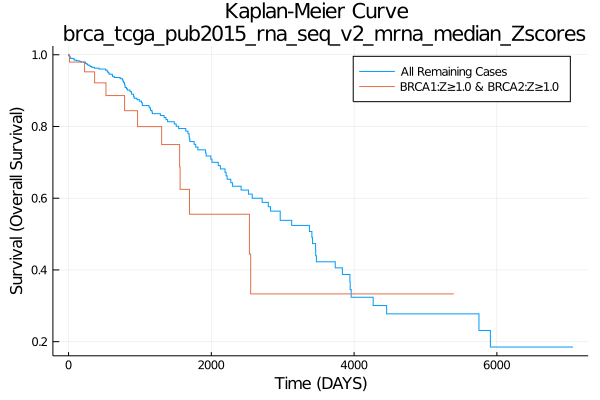

In [49]:
plot_km_results(km_results, config, clinical_outcome, clinical_time_units)

And the Cox proportional hazards model:

In [79]:
function perform_cox(joined)
    joined.EVENT = EventTime.(joined.TIME, Bool.(joined.STATUS))
    joined.GROUP_INT = map(row -> row.GROUP == "CONTROL" ? 0 : row.GROUP == "TEST" ? 1 : -1, eachrow(joined))
    cox_model = coxph(@formula(EVENT ~ GROUP_INT), joined)
    coefs = coeftable(cox_model)
    results = Dict(
        "p_value" => coefs.cols[4],
        "estimate" => coefs.cols[1]
    )
    return results
end

perform_cox (generic function with 1 method)

In [80]:
perform_cox(joined)

Dict{String,Array{Float64,1}} with 2 entries:
  "p_value"  => [0.153884]
  "estimate" => [0.435464]

In [93]:
joined.EVENT = EventTime.(joined.TIME, Bool.(joined.STATUS))
joined.GROUP_INT = map(row -> row.GROUP == "CONTROL" ? 1 : row.GROUP == "TEST" ? 0 : -1, eachrow(joined))
cox_model = coxph(@formula(EVENT ~ GROUP_INT), joined)


StatsModels.TableRegressionModel{CoxModel{Float64},Array{Float64,2}}

EVENT ~ GROUP_INT

Coefficients:
───────────────────────────────────────────────────
            Estimate  Std.Error   z value  Pr(>|z|)
───────────────────────────────────────────────────
GROUP_INT  -0.435464   0.305386  -1.42594    0.1539
───────────────────────────────────────────────────

In [94]:
coefs = coeftable(cox_model)

───────────────────────────────────────────────────
            Estimate  Std.Error   z value  Pr(>|z|)
───────────────────────────────────────────────────
GROUP_INT  -0.435464   0.305386  -1.42594    0.1539
───────────────────────────────────────────────────

$\lambda(t | X_i) = \lambda_0(t) \exp(X_i \cdot \beta)$

In [99]:
coefs.cols[4][1]

0.15388439909444282

The p-value can be extracted and returned, along with the estimate. 

## Putting it all Together

These measures can be wrapped together in a single function that will take a single JSON configuration, and return the result (bar any errors). This can be wrapped in a try block to catch any errors that might occur and return useful information.

In [39]:
function perform_survival_analysis(config_json)
    local clinicaldata, clinicalevent, clinicaltimeunit, moleculardata
    config = parse_config(config_json)
    @sync begin
        @async begin
            clinicaldata_dict = get_clinicaldata(config)
            (clinicaldata, clinicalevent, clinicaltimeunit) = preprocess_clinicaldata(clinicaldata_dict)
        end

        @async begin
            moleculardata_dict = get_moleculardata(config)
            moleculardata = preprocess_moleculardata(moleculardata_dict, config)
        end
    end
    
    # Join the data
    joined = join_data(clinicaldata, moleculardata)
    
    # Perform statistics
    km = perform_km(joined)
    cox = perform_cox(joined)
        
    # Aggregate
    result = Dict(
        "km" => km,
        "cox" => cox,
        "event_type" => clinicalevent,
        "event_time_unit" => clinicaltimeunit
    )
    
    return result
end

perform_survival_analysis (generic function with 1 method)

And an interactive version for visualisation here:

In [79]:
function interactive_perform_survival(config_json)
    config = parse_config(config_json)
    result = perform_survival_analysis(config_json)
    println(result["cox"])
    plot_km_results(result["km"], config, result["event_type"], result["event_time_unit"])
end

interactive_perform_survival (generic function with 1 method)

We can now supply this with arbitrary configurations and return the results.

Dict("p_value" => [0.023221356411472185],"estimate" => [0.6302145034233457])


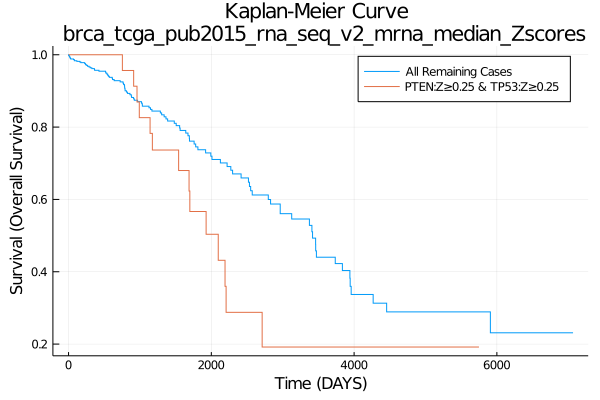

In [80]:
interactive_perform_survival(config_json)

In [81]:
config_json = """
{ 
    "study_id": "brca_tcga_pub2015", 
    "molecular_profile_id": "brca_tcga_pub2015_rna_seq_v2_mrna_median_Zscores",
    "genes": [
        { "hugo": "BRCA1",
          "entrez": 672,
          "side": "above",
          "zscore": 1.5 },
        { "hugo": "BRCA2",
          "entrez": 675,
          "side": "above",
          "zscore": 1.5 }
    ]
}
"""

"{ \n    \"study_id\": \"brca_tcga_pub2015\", \n    \"molecular_profile_id\": \"brca_tcga_pub2015_rna_seq_v2_mrna_median_Zscores\",\n    \"genes\": [\n        { \"hugo\": \"BRCA1\",\n          \"entrez\": 672,\n          \"side\": \"above\",\n          \"zscore\": 1.5 },\n        { \"hugo\": \"BRCA2\",\n          \"entrez\": 675,\n          \"side\": \"above\",\n          \"zscore\": 1.5 }\n    ]\n}\n"

Dict("p_value" => [0.019521131570211573],"estimate" => [0.9175591079036169])


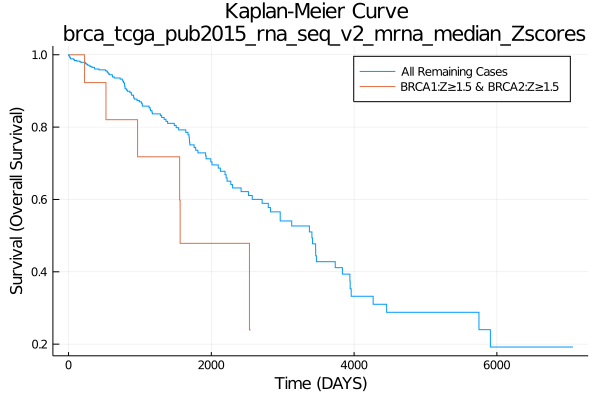

In [82]:
interactive_perform_survival(config_json)

In [83]:
config_json = """
{ 
    "study_id": "brca_tcga_pub2015", 
    "molecular_profile_id": "brca_tcga_pub2015_rna_seq_v2_mrna_median_Zscores",
    "genes": [
        { "hugo": "PTEN",
          "entrez": 5728,
          "side": "above",
          "zscore": 0.25 },
        { "hugo": "TP53",
          "entrez": 7157,
          "side": "above",
          "zscore": 0.25 }
    ]
}
"""

"{ \n    \"study_id\": \"brca_tcga_pub2015\", \n    \"molecular_profile_id\": \"brca_tcga_pub2015_rna_seq_v2_mrna_median_Zscores\",\n    \"genes\": [\n        { \"hugo\": \"PTEN\",\n          \"entrez\": 5728,\n          \"side\": \"above\",\n          \"zscore\": 0.25 },\n        { \"hugo\": \"TP53\",\n          \"entrez\": 7157,\n          \"side\": \"above\",\n          \"zscore\": 0.25 }\n    ]\n}\n"

Dict("p_value" => [0.023221356411472185],"estimate" => [0.6302145034233457])


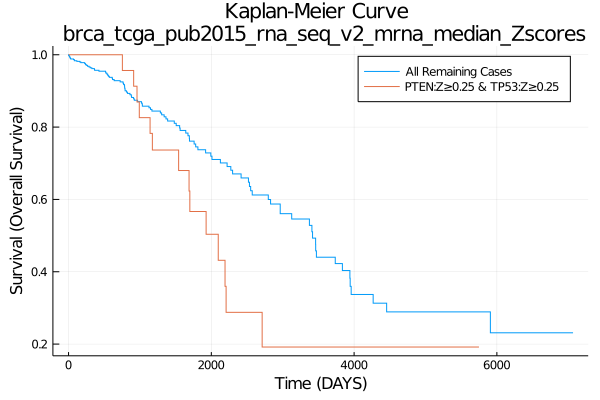

In [84]:
interactive_perform_survival(config_json)